# How to predict solar energy production
This is notebook for article: [INSERT LINK AFTER PUBLICATION](INSERTLINKAFTERPUBLICATION)

In [1]:
import pandas as pd
import numpy as np
import requests
import pytz, datetime
import matplotlib.pyplot as plt

from yaspin import yaspin

In [2]:
%matplotlib inline
plt.style.use('seaborn-darkgrid')
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
rcParams['font.sans-serif'] = ['Lucida Console']

In [10]:
#API KEYS and other global variables
API_KEY = '' #####DELETE######
SITE_ID = '' #####DELETE######

#Important dates
PRODUCTION_STARTED_AT = '2019-05-09' #This is specific
TODAY = datetime.datetime.now().strftime("%Y-%m-%d")
TODAY = '2020-12-10'

#Filenames
energy_filename = f"energy_{TODAY}.csv"

#Configuration
LATITUDE = 53.79019975994694
LONGITUDE = 19.64142672729693

## Data collecting

Simple SolarEdge API client

In [11]:
from astral.sun import sun
from astral.sun import daylight
from astral import LocationInfo

class Helpers:
    @staticmethod
    def localtime_to_utc(date, local_timezone="Europe/Warsaw"):
        local = pytz.timezone(local_timezone)
        naive = datetime.datetime.strptime (date, "%Y-%m-%d %H:%M:%S")
        local_dt = local.localize(naive, is_dst=True)
        utc_dt = local_dt.astimezone(pytz.utc)
        return utc_dt.strftime ("%Y-%m-%d %H:%M:%S")
    
    @staticmethod
    def generate_daylight(start_date, end_date):
        datelist = pd.date_range(start_date, end=end_date).tolist()
        daylightData = pd.DataFrame(columns=['date','daylight','sunrise','sunset'])
        for date in datelist:
            daylight = Helpers.getDaylight(date)
            daylightData = daylightData.append({
                "date": date, 
                "daylight": daylight['duration'],
                "sunrise": daylight['sunrise'],
                "sunset": daylight['sunset']
            }, ignore_index=True)
        return daylightData
    
    @staticmethod
    def getDaylight(start_date, timezone="Europe/Warsaw"):
        city = LocationInfo("Skitlawki", "Poland", timezone, LATITUDE, LONGITUDE)
        s = sun(city.observer, date=start_date)
        return {
            "duration": (s['sunset'] - s['sunrise']).seconds,
            "sunrise": s['sunrise'].strftime ("%Y-%m-%d %H:%M:%S"),
            "sunset": s['sunset'].strftime ("%Y-%m-%d %H:%M:%S")
        }

class SolarEdgeClient:
    def __init__(self, key):
        self.key = key
    
    def show_key(self):
        print(self.key)
    
    def getDataPeriod(self, site_id):  
        url = f"https://monitoringapi.solaredge.com/site/{site_id}/dataPeriod?api_key={self.key}"
        response = requests.request("GET", url, headers={}, data = {})
        data = response.json()
        return (data['dataPeriod']['startDate'], data['dataPeriod']['endDate'])

    def getSiteEnergy(self, site_id, start_date, end_date, time_unit='DAY'):
        url = f"https://monitoringapi.solaredge.com/site/{site_id}/energy?timeUnit={time_unit}&endDate={end_date}&startDate={start_date}&api_key={self.key}"
        response = requests.request("GET", url, headers={}, data = {}) 
        data = response.json()
        
        return data['energy']['values']
    
    def getSiteDetails(self, site_id):
        url = f"https://monitoringapi.solaredge.com/site/{site_id}/details?api_key={self.key}"
        response = requests.request("GET", url, headers={}, data = {}) 
        data = response.json()
        
        return data['details']
    
    
    def read_site_energy(self, site_id, start_date, end_date, time_unit='DAY'):
        site_details = self.getSiteDetails(site_id)
        datelist = pd.date_range(start_date, end=end_date).tolist()
        energyData = pd.DataFrame()
        for date in datelist:
            dailyData = self.getSiteEnergy(site_id=site_id, start_date=date.strftime("%Y-%m-%d"), end_date=date.strftime("%Y-%m-%d"), time_unit=time_unit)
            temporary_df = pd.DataFrame.from_records(dailyData)
            if(time_unit != 'DAY'):
                temporary_df['date'] = temporary_df['date'].apply(lambda date: Helpers.localtime_to_utc(date, site_details['location']['timeZone']))
            energyData = pd.concat([energyData, temporary_df])
        return energyData

In [12]:
client = SolarEdgeClient(key=API_KEY)

In [13]:
START_DATE, END_DATE = client.getDataPeriod(site_id=SITE_ID)

#######For article only#######
START_DATE = PRODUCTION_STARTED_AT
END_DATE = '2020-12-10'
##############################

LOCAL_TIMEZONE = client.getSiteDetails(site_id=SITE_ID)['location']['timeZone']

To avoid API overuse, I download data only if there are no file for today.

In [22]:
try:
    energy = pd.read_csv(energy_filename)
except:
    energy = client.read_site_energy(site_id=SITE_ID, start_date=START_DATE, end_date=END_DATE, time_unit='DAY')
    energy.to_csv(energy_filename, index=False)

In [23]:
energy['date'] = pd.to_datetime(energy['date'])
energy.rename(columns={'date':'ds', 'value': 'y'}, inplace=True)
energy.set_index('ds', inplace=True)
energy['ds'] = energy.index
energy.head()
MAXIMUM_ENERGY = max(energy['y'])

<AxesSubplot:ylabel='Density'>

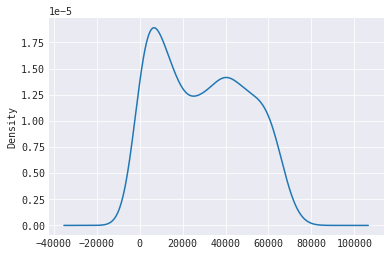

In [24]:
energy['y'].plot.density()

In [25]:
#Forecast Evaluation Statistics
class FES:
    @staticmethod
    def me(f,y):
        f = f.reset_index(drop=True).values.flatten()
        y = y.reset_index(drop=True).values.flatten()
        df = pd.DataFrame({'f_i':f, 'y_i': y})
        df['e'] = df['y_i'] - df['f_i']
        return np.mean(df['e'])
    
    @staticmethod
    def mse(f, y):
        f = f.reset_index(drop=True).values.flatten()
        y = y.reset_index(drop=True).values.flatten()
        df = pd.DataFrame({'f_i':f, 'y_i': y})
        df['e'] = np.square(df['y_i'] - df['f_i'])
        return np.mean(df['e'])

    @staticmethod
    def rmse(f, y):
        return np.sqrt(FES.mse(f,y))

    @staticmethod
    def mae(f, y):
        f = f.reset_index(drop=True).values.flatten()
        y = y.reset_index(drop=True).values.flatten()
        df = pd.DataFrame({'f_i':f, 'y_i': y})
        df['e'] = np.abs(df['y_i'] - df['f_i'])
        return np.mean(df['e'])

    @staticmethod
    def mpe(f, y):
        f = f.reset_index(drop=True).values.flatten()
        y = y.reset_index(drop=True).values.flatten()
        df = pd.DataFrame({'f_i':f, 'y_i': y})
        df['e'] = df['y_i'] - df['f_i']
        df['pe'] = 100*(df['e']/df['y_i'])
        return np.mean(df['pe'])

    @staticmethod
    def mape(f, y):
        f = f.reset_index(drop=True).values.flatten()
        y = y.reset_index(drop=True).values.flatten()
        df = pd.DataFrame({'f_i':f, 'y_i': y})
        df['e'] = df['y_i'] - df['f_i']
        df['ape'] = 100*np.abs(df['e']/df['y_i'])
        return np.mean(df['ape'])
    
    @staticmethod
    def all(f, y):
        return (
            FES.me(f,y),
            FES.mse(f,y),
            FES.rmse(f,y),
            FES.mae(f,y),
            FES.mpe(f,y),
            FES.mape(f,y),
            FES.u1(f,y),
            FES.u2(f,y)
        )

    @staticmethod
    def u1(f,y):
        y = y.reset_index(drop=True).values.flatten()
        f = f.reset_index(drop=True).values.flatten()
        df = pd.DataFrame({'f_i':f, 'y_i': y})
        df['(f_i - y_i)^2'] = np.square(df['f_i'] - df['y_i'])
        df['y_i^2'] = np.square(df['y_i'])
        df['f_i^2'] = np.square(df['f_i'])
        return (np.sqrt(np.mean(df['(f_i - y_i)^2'])))/(np.sqrt(np.mean(df['y_i^2']))+np.sqrt(np.mean(df['f_i^2'])))

    @staticmethod
    def u2(f,y):
        y = y.reset_index(drop=True).values.flatten()
        f = f.reset_index(drop=True).values.flatten()
        df = pd.DataFrame({'f_i+1':f, 'y_i+1': y})
        df['y_i'] = df['y_i+1'].shift(periods=1)
        df['numerator'] = np.square((df['f_i+1'] - df['y_i+1']) / df['y_i'])
        df['denominator'] = np.square((df['y_i+1'] - df['y_i']) / df['y_i'])
        df.dropna(inplace=True)
        return np.sqrt(np.sum(df['numerator'])/np.sum(df['denominator']))

,ME,MSE,RMSE,MAE,MPE,MAPE,U1,U2
Method,,,,,,,,
Naive,-55.523236,2.708348e+08,16457.060565,12150.876076,-71.022923,111.165561,0.231815,1.000000
Moving Average,-103.762111,1.891160e+08,13751.945776,10416.414360,-83.461715,112.242082,0.197762,0.791995


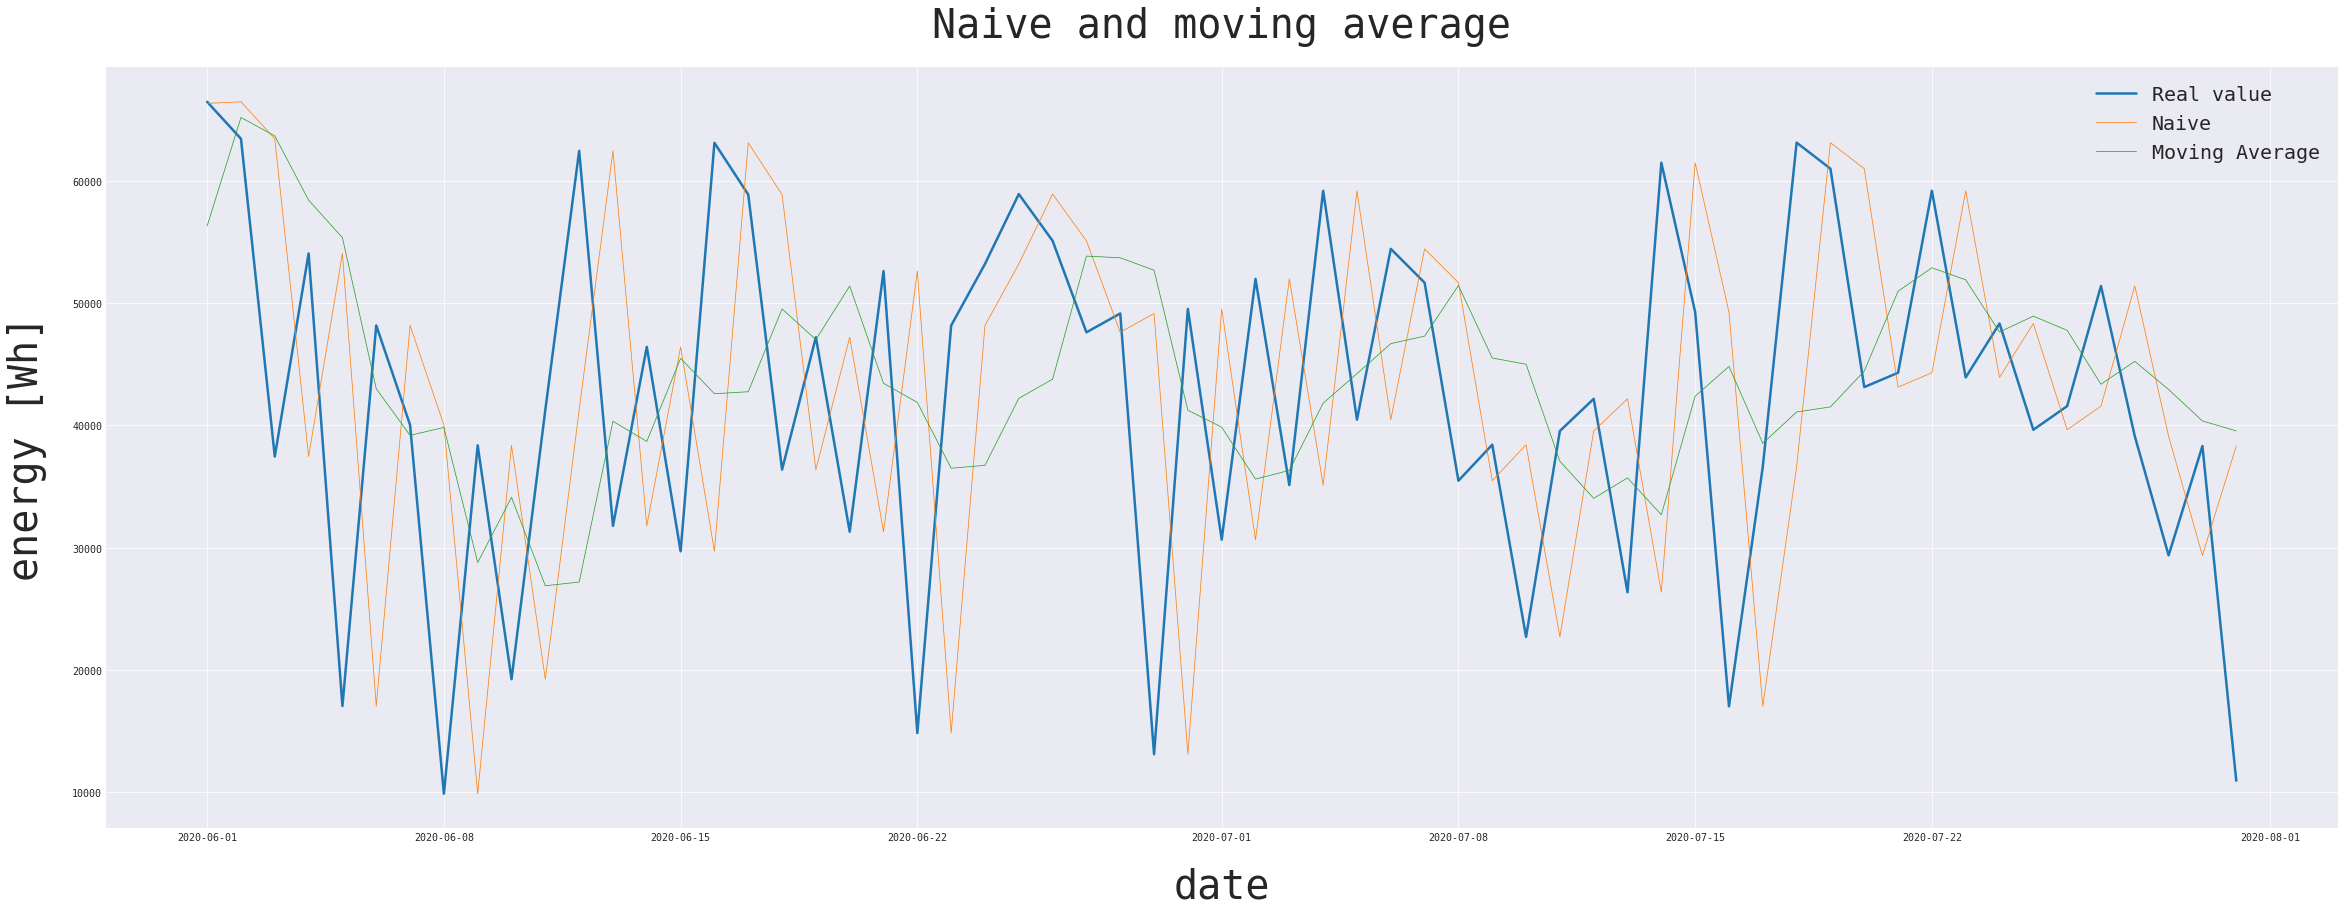

In [26]:
data = energy.copy()
data['cap'] = data['y'].max()
data['floor'] = 0.0
simple_methods = []
### Naive
MODEL = 'Naive'
data[MODEL] = data['y'].shift(periods=1)
arg = (data[MODEL], data['y'])
simple_methods.append([MODEL, *FES.all(*arg)])

### Moving Average
MODEL = 'Moving Average'
data[MODEL] = data['y'].rolling(4).mean().shift(periods=1)
arg = (data[MODEL], data['y'])
simple_methods.append([MODEL, *FES.all(*arg)])

simple_methods_df = pd.DataFrame(simple_methods, columns= ['Method', 'ME', 'MSE', 'RMSE', 'MAE', 'MPE', 'MAPE', 'U1', 'U2'])
display(simple_methods_df.set_index('Method'))
simple_methods_df.to_html('naive_and_moving_average.html', index=False)
                                                 
plot_data = data['2020-06':'2020-07']
fig = plt.figure(figsize=(40,14))
plt.xlabel('date',fontsize=40, labelpad=25)
plt.ylabel('energy [Wh]',fontsize=40, labelpad=25)
plt.plot(plot_data['y'], linewidth=2.5)
plt.plot(plot_data['Naive'], linewidth=0.75)
plt.plot(plot_data['Moving Average'], linewidth=0.75)
plt.legend(['Real value','Naive','Moving Average'], prop={'size': 20})
plt.title('Naive and moving average',fontsize=40, pad=30)
                                                 
# plt.show()
plt.savefig('naive_and_moving_average.png')

In [27]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation

def moving_average(train, test):
    data = pd.concat([train,test])
    data['ma'] = data['y'].rolling(4).mean().shift(periods=1)
    return data.loc[test['ds'].min():]['ma']


def prophet_without_regressors(train, test):
    m = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True, growth='logistic')
    m.fit(train)
    forecast = m.predict(test)
    forecast['yhat'] = forecast['yhat'].apply(lambda x: 0 if x<0 else x)
    return forecast.set_index('ds')['yhat']

def cross_validation(data, model=prophet_without_regressors):
    date_range = (data['ds'].min()+datetime.timedelta(days=365), data['ds'].max())
    datelist = pd.date_range(*date_range, freq='5D').tolist()
    evaluation_statistics = []
    for i in range(len(datelist)):
        if (i == len(datelist) - 1):
            continue
        train_end = datelist[i]
        test_start = datelist[i] + datetime.timedelta(days=1)
        test_end = test_start + datetime.timedelta(days=5)
        if(test_end > data['ds'].max()):
            test_end = data['ds'].max()
        else:
            test_end = datelist[i] + datetime.timedelta(days=5)
        train_end = datetime.datetime.strftime(train_end, '%Y-%m-%d')
        test_start = datetime.datetime.strftime(test_start, '%Y-%m-%d')
        test_end = datetime.datetime.strftime(test_end, '%Y-%m-%d')
        
        train = data[:train_end].copy()
        test = data[test_start:test_end].copy()
        train['ds'] = train.index
        test['ds'] = test.index

        evaluation_statistics.append([f":{train_end} | {test_start} - {test_end}",*FES.all(model(train, test), test['y'])])
    evaluation_statistics = pd.DataFrame(evaluation_statistics, columns= ['period','ME', 'MSE', 'RMSE', 'MAE', 'MPE', 'MAPE', 'U1', 'U2'])
    return evaluation_statistics

CV_evaluation = {}
with yaspin().moon as sp:
    CV_evaluation['Moving Average'] = cross_validation(data, model=moving_average)
    CV_evaluation['Prophet without regressors'] = cross_validation(data)

In [28]:
ma_vs_prophet_wo_regressors = pd.DataFrame(CV_evaluation['Moving Average'].mean()).transpose()
ma_vs_prophet_wo_regressors = ma_vs_prophet_wo_regressors.append(pd.DataFrame(CV_evaluation['Prophet without regressors'].mean()).transpose())
ma_vs_prophet_wo_regressors['model'] = ['Moving Average','Prophet without regressors']
ma_vs_prophet_wo_regressors.set_index('model', inplace=True)
display(ma_vs_prophet_wo_regressors)
ma_vs_prophet_wo_regressors.to_html('ma_vs_prophet_wo_regressors.html')

,ME,MSE,RMSE,MAE,MPE,MAPE,U1,U2
model,,,,,,,,
Moving Average,-581.856977,2.064222e+08,13109.980501,10977.422093,-60.078129,85.785519,0.245735,0.865015
Prophet without regressors,-1300.862027,2.355665e+08,13746.089570,11722.623883,-37.836540,72.043319,0.272606,0.928225


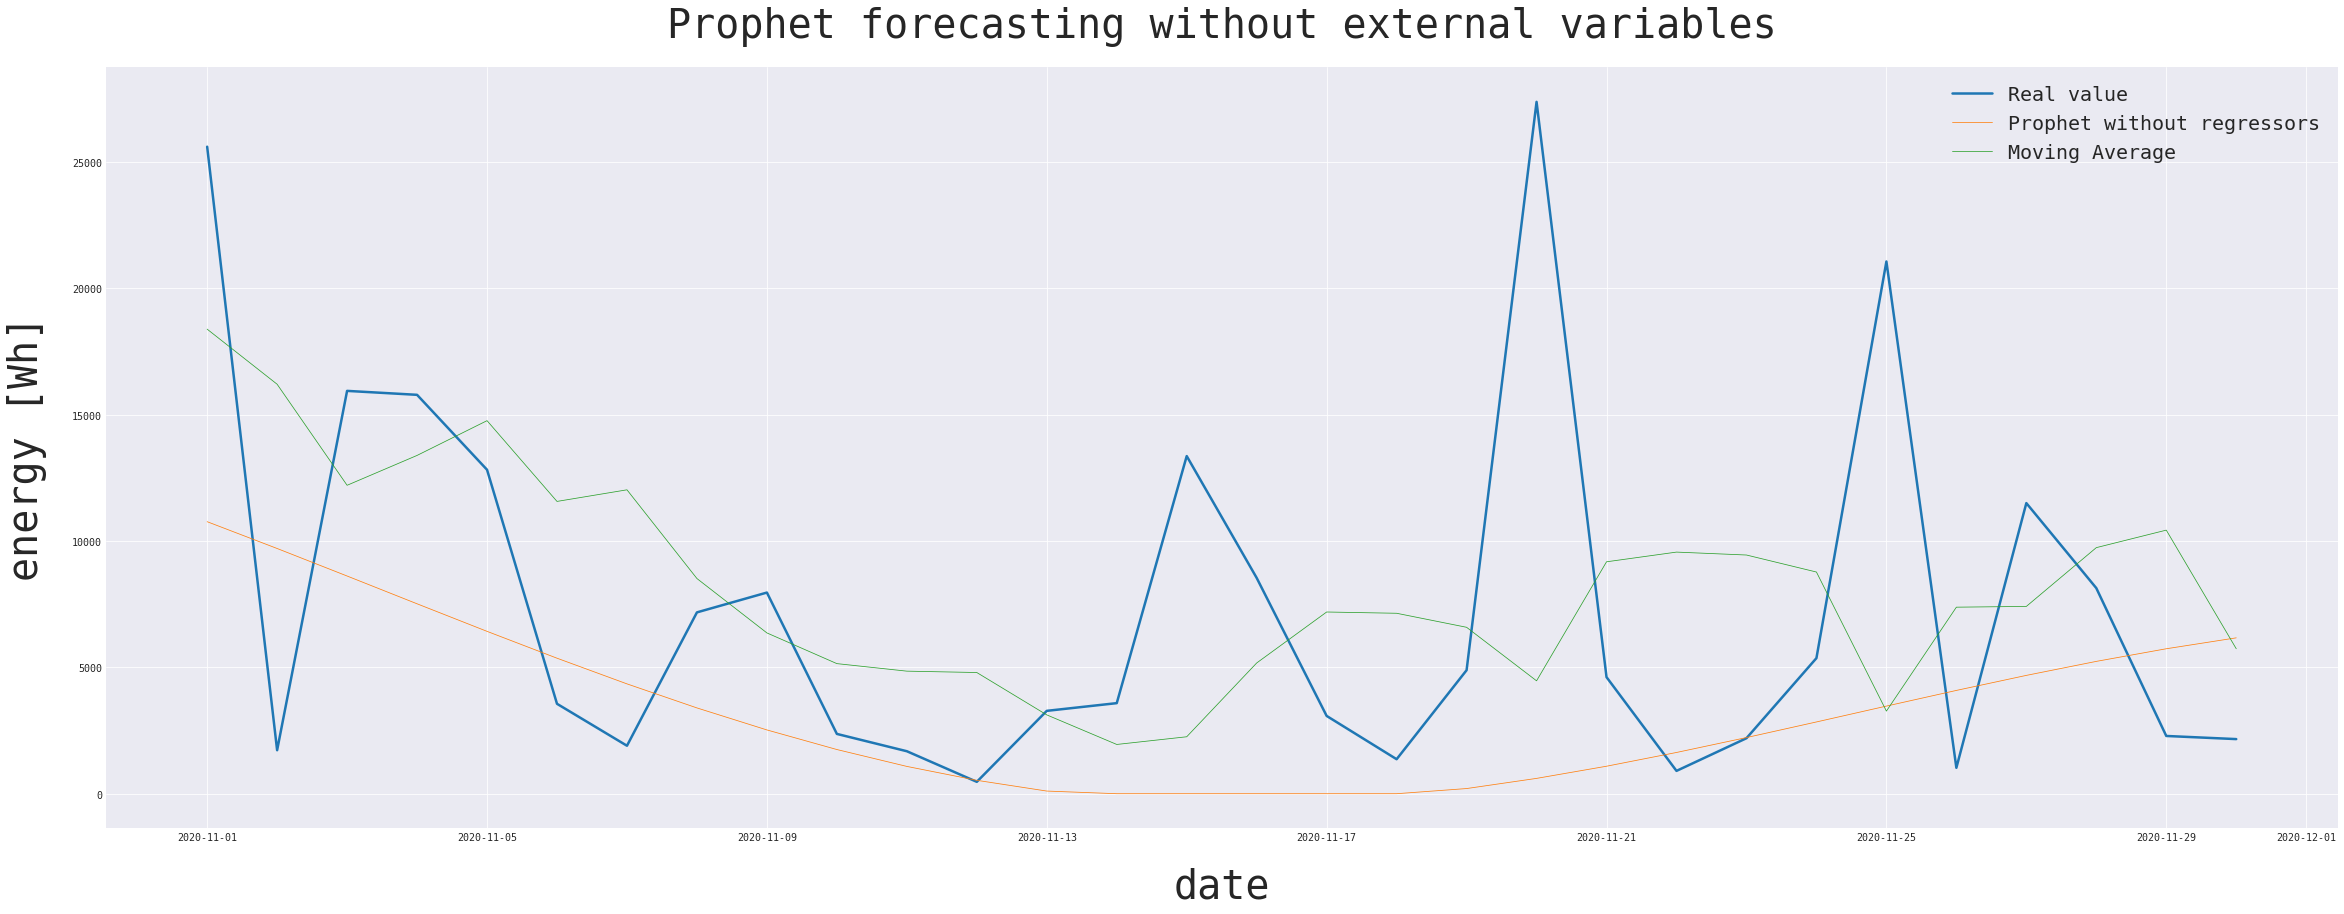

In [14]:
train = data.set_index('ds')[:'2020-10'].copy()
test = data.set_index('ds')['2020-11'].copy()
train['ds'] = train.index
test['ds'] = test.index

test['Prophet without regressors'] = prophet_without_regressors(train, test)

plot_data = test
fig = plt.figure(figsize=(40,14))
plt.xlabel('date',fontsize=40, labelpad=25)
plt.ylabel('energy [Wh]',fontsize=40, labelpad=25)
plt.plot(plot_data['y'], linewidth=2.5)
plt.plot(plot_data['Prophet without regressors'], linewidth=0.75)
plt.plot(plot_data['Moving Average'], linewidth=0.75)
plt.legend(['Real value','Prophet without regressors','Moving Average'], prop={'size': 20})
plt.title('Prophet forecasting without external variables',fontsize=40, pad=30)
                                                 
plt.show()
# plt.savefig('prophet_without_regressors.png')

## Weather historical data

In [14]:
meteoblue = pd.read_csv('meteoblue.csv')
meteoblue['timestamp'] = pd.to_datetime(meteoblue['timestamp'])
meteoblue['date'] = meteoblue['timestamp'].apply(lambda x: x.strftime ("%Y-%m-%d"))
meteoblue['date'] = pd.to_datetime(meteoblue['date'])
meteoblue = meteoblue.rename(columns={'timestamp': 'ds'})
meteoblue = meteoblue.loc[meteoblue['date'] >= START_DATE]
display(meteoblue.head())

,ds,Temperature [2 m elevation corrected],Growing Degree Days [2 m elevation corrected],Temperature [1000 mb],Temperature [850 mb],Temperature [700 mb],Precipitation Total,Snowfall Amount,Relative Humidity [2 m],Wind Speed [10 m],...,Geopotential Height [850 mb],Geopotential Height [700 mb],Geopotential Height [500 mb],Evapotranspiration,FAO Reference Evapotranspiration [2 m],Temperature,Soil Temperature [0-10 cm down],Soil Moisture [0-10 cm down],Vapor Pressure Deficit [2 m],date
99504,2019-05-09 00:00:00,7.845558,0.0,9.28,2.52,-6.10,0.0,0.0,57.0,26.208397,...,1415.0,2953.0,5513.0,0.01440,0.074823,6.28,8.839996,0.227,4.516595,2019-05-09
99505,2019-05-09 01:00:00,7.495558,0.0,8.91,2.71,-5.85,0.0,0.0,57.0,26.649727,...,1407.0,2945.0,5508.0,0.01296,0.074323,6.09,8.459991,0.226,4.409857,2019-05-09
99506,2019-05-09 02:00:00,7.835558,0.0,8.78,2.81,-5.28,0.0,0.0,55.0,28.800000,...,1402.0,2942.0,5506.0,0.01440,0.083204,6.89,8.170013,0.226,4.723447,2019-05-09
99507,2019-05-09 03:00:00,7.995558,0.0,8.71,2.90,-5.07,0.0,0.0,54.0,30.248568,...,1397.0,2938.0,5502.0,0.01728,0.088358,7.16,8.010010,0.226,4.881398,2019-05-09
99508,2019-05-09 04:00:00,8.525558,0.0,8.81,2.95,-4.99,0.0,0.0,55.0,31.485083,...,1390.0,2932.0,5496.0,0.03888,0.094493,8.22,7.950012,0.226,4.950570,2019-05-09


## Daylight data

In [15]:
daylight = Helpers.generate_daylight(START_DATE, '2020-12-31')
daylight.head()

,date,daylight,sunrise,sunset
0,2019-05-09,56060,2019-05-09 02:51:18,2019-05-09 18:25:38
1,2019-05-10,56276,2019-05-10 02:49:27,2019-05-10 18:27:23
2,2019-05-11,56488,2019-05-11 02:47:39,2019-05-11 18:29:07
3,2019-05-12,56699,2019-05-12 02:45:52,2019-05-12 18:30:51
4,2019-05-13,56906,2019-05-13 02:44:07,2019-05-13 18:32:33


In [16]:
dataset = pd.merge(left=meteoblue, right=daylight)
dataset['sunrise'] = pd.to_datetime(dataset['sunrise'])
dataset['sunset'] = pd.to_datetime(dataset['sunset'])
dataset['is_day'] = dataset[['ds','sunrise','sunset']].apply(lambda x: x['sunrise'] <= x['ds'] <= x['sunset'],  axis=1)
display(dataset.head())

,ds,Temperature [2 m elevation corrected],Growing Degree Days [2 m elevation corrected],Temperature [1000 mb],Temperature [850 mb],Temperature [700 mb],Precipitation Total,Snowfall Amount,Relative Humidity [2 m],Wind Speed [10 m],...,FAO Reference Evapotranspiration [2 m],Temperature,Soil Temperature [0-10 cm down],Soil Moisture [0-10 cm down],Vapor Pressure Deficit [2 m],date,daylight,sunrise,sunset,is_day
0,2019-05-09 00:00:00,7.845558,0.0,9.28,2.52,-6.10,0.0,0.0,57.0,26.208397,...,0.074823,6.28,8.839996,0.227,4.516595,2019-05-09,56060,2019-05-09 02:51:18,2019-05-09 18:25:38,False
1,2019-05-09 01:00:00,7.495558,0.0,8.91,2.71,-5.85,0.0,0.0,57.0,26.649727,...,0.074323,6.09,8.459991,0.226,4.409857,2019-05-09,56060,2019-05-09 02:51:18,2019-05-09 18:25:38,False
2,2019-05-09 02:00:00,7.835558,0.0,8.78,2.81,-5.28,0.0,0.0,55.0,28.800000,...,0.083204,6.89,8.170013,0.226,4.723447,2019-05-09,56060,2019-05-09 02:51:18,2019-05-09 18:25:38,False
3,2019-05-09 03:00:00,7.995558,0.0,8.71,2.90,-5.07,0.0,0.0,54.0,30.248568,...,0.088358,7.16,8.010010,0.226,4.881398,2019-05-09,56060,2019-05-09 02:51:18,2019-05-09 18:25:38,True
4,2019-05-09 04:00:00,8.525558,0.0,8.81,2.95,-4.99,0.0,0.0,55.0,31.485083,...,0.094493,8.22,7.950012,0.226,4.950570,2019-05-09,56060,2019-05-09 02:51:18,2019-05-09 18:25:38,True


In [17]:
df = dataset.loc[dataset['is_day']].drop('is_day', axis=1)

aggregations_dict = {
    'Temperature [2 m elevation corrected]': 'mean',
    'Temperature [1000 mb]': 'mean',
    'Temperature [850 mb]': 'mean',
    'Temperature [700 mb]': 'mean',
    'Precipitation Total': 'sum',
    'Snowfall Amount': 'sum',
    'Relative Humidity [2 m]': 'mean',
    'Wind Speed [10 m]': 'mean',
    'Wind Direction [10 m]': 'mean',
    'Wind Speed [80 m]': 'mean',
    'Wind Direction [80 m]': 'mean',
    'Wind Gust': 'mean',
    'Wind Speed [900 mb]': 'mean',
    'Wind Direction [900 mb]': 'mean',
    'Wind Speed [850 mb]': 'mean',
    'Wind Direction [850 mb]': 'mean',
    'Wind Speed [700 mb]': 'mean',
    'Wind Direction [700 mb]': 'mean',
    'Wind Speed [500 mb]': 'mean',
    'Wind Direction [500 mb]': 'mean',
    'Cloud Cover Total': 'mean',
    'Cloud Cover High [high cld lay]': 'mean', 
    'Cloud Cover Medium [mid cld lay]': 'mean',
    'Cloud Cover Low [low cld lay]': 'mean',
    'CAPE [180-0 mb above gnd]': 'mean',
    'Sunshine Duration': 'sum',
    'Shortwave Radiation': 'mean',
    'Direct Shortwave Radiation': 'mean', 
    'Diffuse Shortwave Radiation': 'mean',
    'Mean Sea Level Pressure [MSL]': 'mean',
    'Geopotential Height [1000 mb]': 'mean',
    'Geopotential Height [850 mb]': 'mean',
    'Geopotential Height [700 mb]': 'mean',
    'Geopotential Height [500 mb]': 'mean',
    'Evapotranspiration': 'mean',
    'FAO Reference Evapotranspiration [2 m]': 'mean',
    'Temperature': 'mean',
    'Soil Temperature [0-10 cm down]': 'mean',
    'Soil Moisture [0-10 cm down]': 'mean',
    'Vapor Pressure Deficit [2 m]': 'mean',
    'daylight': 'mean',
}


for key in aggregations_dict.keys():
    df[key] = pd.to_numeric(df[key])

df = df.resample('D', on='ds').agg(aggregations_dict).reset_index()

In [18]:
df.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,Temperature [2 m elevation corrected],Temperature [1000 mb],Temperature [850 mb],Temperature [700 mb],Precipitation Total,Snowfall Amount,Relative Humidity [2 m],Wind Speed [10 m],Wind Direction [10 m],Wind Speed [80 m],Wind Direction [80 m],Wind Gust,Wind Speed [900 mb],Wind Direction [900 mb],Wind Speed [850 mb],Wind Direction [850 mb],Wind Speed [700 mb],Wind Direction [700 mb],Wind Speed [500 mb],Wind Direction [500 mb],Cloud Cover Total,Cloud Cover High [high cld lay],Cloud Cover Medium [mid cld lay],Cloud Cover Low [low cld lay],CAPE [180-0 mb above gnd],Sunshine Duration,Shortwave Radiation,Direct Shortwave Radiation,Diffuse Shortwave Radiation,Mean Sea Level Pressure [MSL],Geopotential Height [1000 mb],Geopotential Height [850 mb],Geopotential Height [700 mb],Geopotential Height [500 mb],Evapotranspiration,FAO Reference Evapotranspiration [2 m],Temperature,Soil Temperature [0-10 cm down],Soil Moisture [0-10 cm down],Vapor Pressure Deficit [2 m],daylight
Temperature [2 m elevation corrected],1.00,1.00,0.87,0.82,0.04,-0.16,-0.42,-0.45,-0.16,-0.41,-0.16,-0.39,-0.38,-0.19,-0.32,-0.18,-0.27,-0.11,-0.31,-0.04,-0.33,0.05,-0.05,-0.38,0.48,0.51,0.64,0.59,0.69,-0.05,-0.01,0.40,0.62,0.74,0.80,0.85,0.99,0.99,-0.47,0.85,0.75
Temperature [1000 mb],1.00,1.00,0.88,0.82,0.06,-0.15,-0.39,-0.43,-0.17,-0.38,-0.16,-0.37,-0.35,-0.18,-0.29,-0.17,-0.25,-0.11,-0.30,-0.04,-0.31,0.08,-0.02,-0.36,0.50,0.48,0.61,0.55,0.66,-0.12,-0.08,0.34,0.58,0.71,0.79,0.82,0.98,0.98,-0.46,0.84,0.73
Temperature [850 mb],0.87,0.88,1.00,0.95,0.09,-0.18,-0.19,-0.36,-0.25,-0.30,-0.25,-0.29,-0.25,-0.21,-0.23,-0.20,-0.21,-0.14,-0.33,-0.09,-0.23,0.18,0.04,-0.30,0.45,0.34,0.40,0.36,0.43,-0.08,-0.04,0.37,0.65,0.81,0.60,0.63,0.84,0.84,-0.43,0.69,0.50
Temperature [700 mb],0.82,0.82,0.95,1.00,0.06,-0.21,-0.18,-0.36,-0.26,-0.30,-0.26,-0.29,-0.26,-0.22,-0.24,-0.21,-0.20,-0.14,-0.30,-0.08,-0.24,0.17,-0.01,-0.31,0.37,0.35,0.40,0.37,0.43,0.03,0.07,0.45,0.71,0.87,0.57,0.61,0.79,0.79,-0.43,0.64,0.47
Precipitation Total,0.04,0.06,0.09,0.06,1.00,0.08,0.34,-0.02,0.02,0.00,0.02,-0.02,0.02,-0.04,0.00,-0.07,0.02,-0.08,0.02,-0.08,0.27,0.20,0.32,0.29,0.12,-0.23,-0.24,-0.29,-0.11,-0.20,-0.20,-0.15,-0.09,-0.04,-0.08,-0.19,0.01,0.07,0.29,-0.18,0.13
Snowfall Amount,-0.16,-0.15,-0.18,-0.21,0.08,1.00,0.13,0.15,0.03,0.13,0.03,0.12,0.13,0.02,0.09,0.05,0.02,0.06,0.02,0.04,0.13,-0.08,0.03,0.16,-0.03,-0.12,-0.13,-0.11,-0.17,-0.08,-0.08,-0.15,-0.19,-0.22,-0.12,-0.14,-0.16,-0.15,0.12,-0.12,-0.13
Relative Humidity [2 m],-0.42,-0.39,-0.19,-0.18,0.34,0.13,1.00,0.20,0.15,0.20,0.14,0.20,0.29,0.16,0.24,0.15,0.16,0.05,0.14,-0.02,0.64,0.15,0.29,0.70,-0.04,-0.66,-0.77,-0.76,-0.71,-0.28,-0.30,-0.41,-0.38,-0.34,-0.53,-0.75,-0.47,-0.37,0.47,-0.74,-0.43
Wind Speed [10 m],-0.45,-0.43,-0.36,-0.36,-0.02,0.15,0.20,1.00,0.12,0.99,0.12,0.95,0.87,0.12,0.80,0.11,0.58,0.04,0.42,0.01,0.26,0.04,0.14,0.26,-0.16,-0.32,-0.38,-0.35,-0.39,-0.26,-0.28,-0.43,-0.48,-0.47,-0.33,-0.36,-0.48,-0.45,0.27,-0.38,-0.35
Wind Direction [10 m],-0.16,-0.17,-0.25,-0.26,0.02,0.03,0.15,0.12,1.00,0.10,0.99,0.16,0.15,0.84,0.19,0.80,0.26,0.68,0.31,0.48,0.15,-0.11,-0.07,0.20,-0.18,-0.15,-0.11,-0.12,-0.09,-0.03,-0.03,-0.12,-0.19,-0.22,-0.11,-0.17,-0.16,-0.12,0.13,-0.22,-0.01
Wind Speed [80 m],-0.41,-0.38,-0.30,-0.30,0.00,0.13,0.20,0.99,0.10,1.00,0.10,0.97,0.91,0.12,0.84,0.11,0.61,0.04,0.44,0.02,0.24,0.09,0.17,0.23,-0.14,-0.32,-0.39,-0.37,-0.40,-0.29,-0.31,-0.44,-0.46,-0.43,-0.32,-0.35,-0.45,-0.42,0.25,-0.36,-0.35


## Final dataset

In [19]:
df = pd.merge(left=data.drop('ds', axis=1).drop(['cap','floor'], axis=1), right=df, left_on='ds', right_on='ds')

correlation_table = df.corr()
target_correlation_table = correlation_table.loc[correlation_table.index == 'y'].transpose()

NameError: name 'data' is not defined

In [21]:
df.head().drop(['Naive','Moving Average'], axis=1).to_csv('final_dataset_sample.csv')

In [22]:
regressors = target_correlation_table.loc[np.abs(target_correlation_table['y']) >= 0.1].index.values
display(regressors)

array(['y', 'Naive', 'Moving Average',
       'Temperature [2 m elevation corrected]', 'Temperature [1000 mb]',
       'Temperature [850 mb]', 'Temperature [700 mb]',
       'Precipitation Total', 'Snowfall Amount',
       'Relative Humidity [2 m]', 'Wind Speed [10 m]',
       'Wind Speed [80 m]', 'Wind Gust', 'Wind Speed [900 mb]',
       'Wind Direction [900 mb]', 'Wind Speed [850 mb]',
       'Wind Direction [850 mb]', 'Wind Speed [700 mb]',
       'Wind Speed [500 mb]', 'Cloud Cover Total',
       'Cloud Cover High [high cld lay]',
       'Cloud Cover Medium [mid cld lay]',
       'Cloud Cover Low [low cld lay]', 'CAPE [180-0 mb above gnd]',
       'Sunshine Duration', 'Shortwave Radiation',
       'Direct Shortwave Radiation', 'Diffuse Shortwave Radiation',
       'Mean Sea Level Pressure [MSL]', 'Geopotential Height [1000 mb]',
       'Geopotential Height [850 mb]', 'Geopotential Height [700 mb]',
       'Geopotential Height [500 mb]', 'Evapotranspiration',
       'FAO Reference 

In [23]:
def prophet_with_regressors(train, test):
    m = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True, growth='logistic')
    for col in train.columns:
        if col in regressors and col not in ['y', 'cap', 'floor','Naive','Moving Average']:
            m.add_regressor(col)

    m.fit(train)

    forecast = m.predict(test)
    forecast['yhat'] = forecast['yhat'].apply(lambda x: 0 if x<0 else x)
    
    return forecast.rename(columns={'yhat':'y'}).set_index('ds')['y']

In [24]:
df.set_index('ds', inplace=True)
df['ds'] = df.index
df['cap'] = df['y'].max()
df['floor'] = 0.0

MODEL = 'Prophet with regressors'
with yaspin().moon as sp:
    CV_evaluation[MODEL] = cross_validation(df, model = prophet_with_regressors)

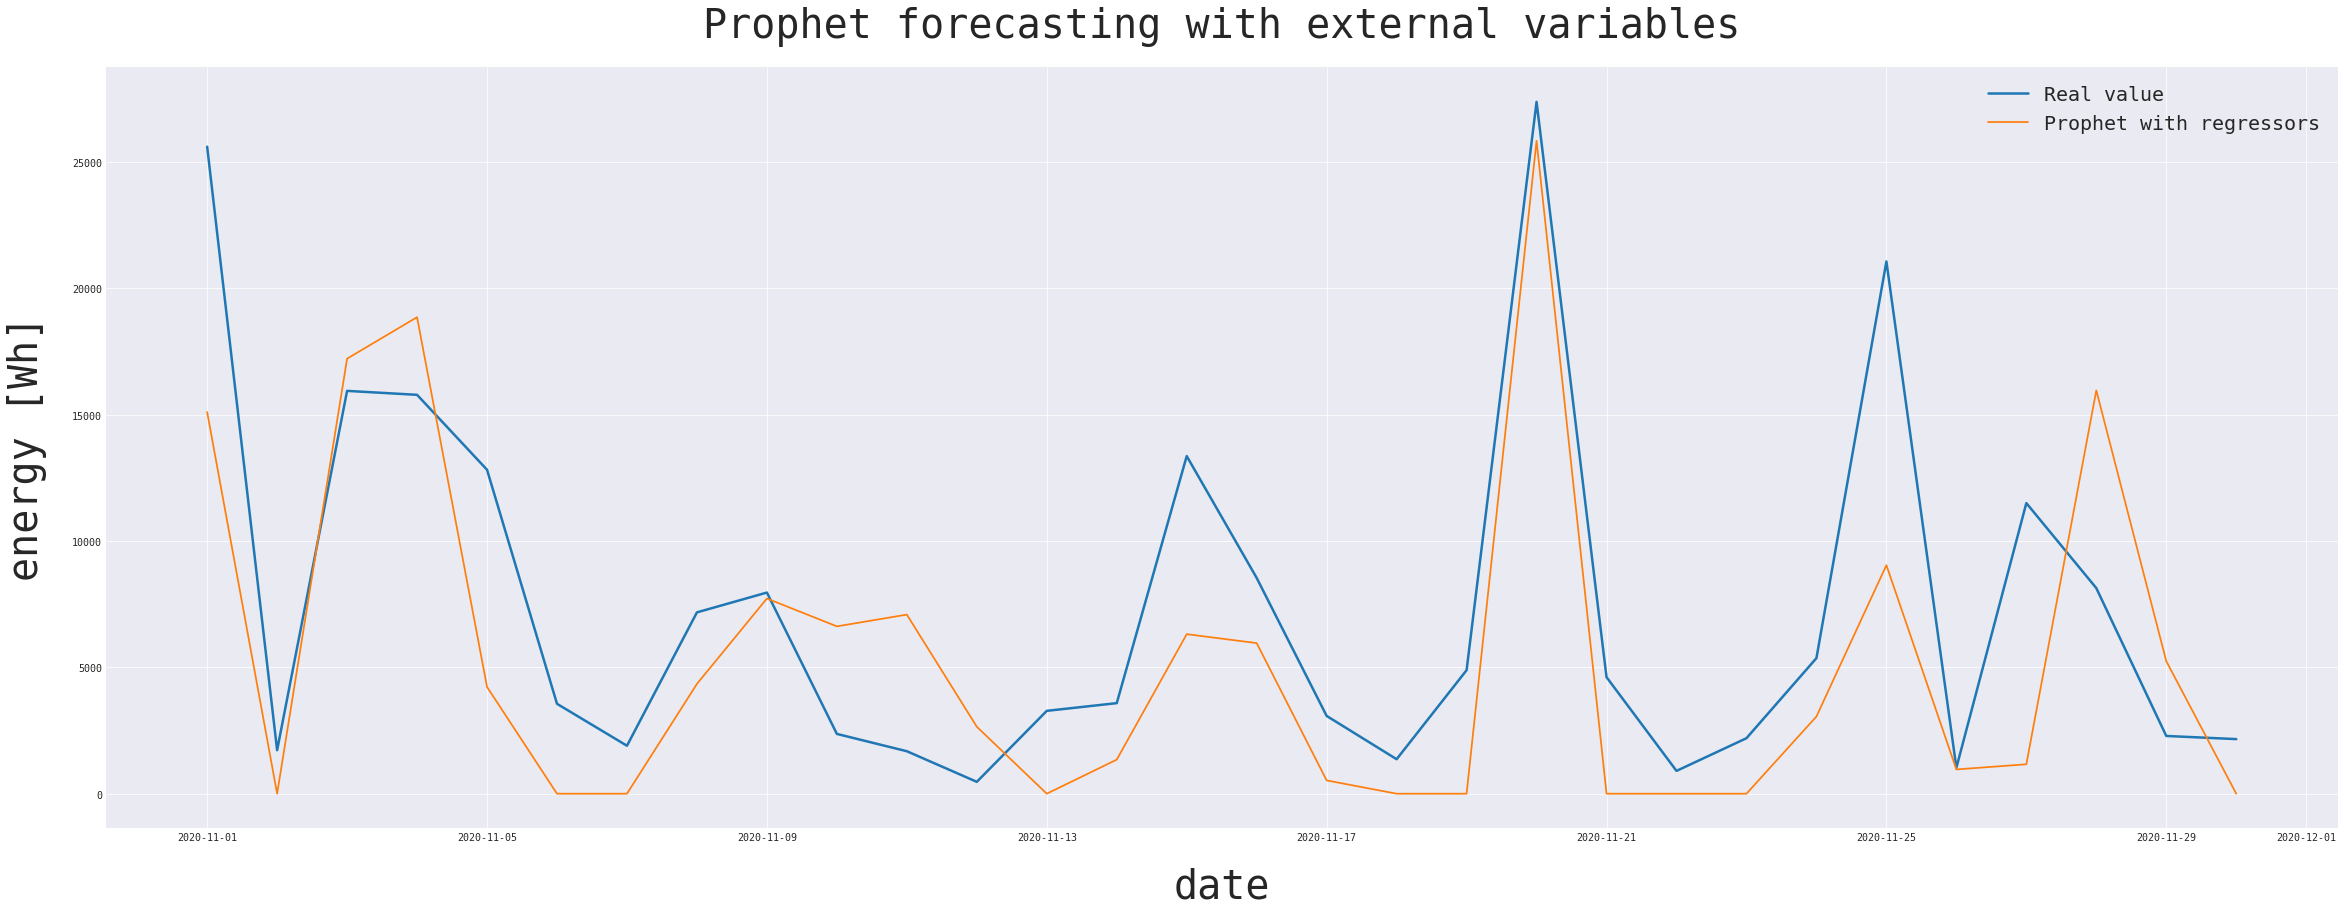

In [25]:
train = df.set_index('ds')[:'2020-10'].copy()
test = df.set_index('ds')['2020-11'].copy()
train['ds'] = train.index
test['ds'] = test.index

test[MODEL] = prophet_with_regressors(train, test)

plot_data = test
fig = plt.figure(figsize=(40,14))
plt.xlabel('date',fontsize=40, labelpad=25)
plt.ylabel('energy [Wh]',fontsize=40, labelpad=25)
plt.plot(plot_data['y'], linewidth=2.5)
plt.plot(plot_data['Prophet with regressors'], linewidth=1.75)
plt.legend(['Real value','Prophet with regressors'], prop={'size': 20})
plt.title('Prophet forecasting with external variables',fontsize=40, pad=30)
                                                 
plt.show()
# plt.savefig('prophet_r.png')

In [26]:
ma_vs_pr = pd.DataFrame(CV_evaluation['Moving Average'].mean()).transpose()
ma_vs_pr = ma_vs_pr.append(pd.DataFrame(CV_evaluation['Prophet without regressors'].mean()).transpose())
ma_vs_pr = ma_vs_pr.append(pd.DataFrame(CV_evaluation['Prophet with regressors'].mean()).transpose())

ma_vs_pr['model'] = ['Moving Average','Prophet without regressors','Prophet with regressors']
ma_vs_pr.set_index('model', inplace=True)
display(ma_vs_pr)
ma_vs_pr.to_html('ma_vs_pr_1.html')

,ME,MSE,RMSE,MAE,MPE,MAPE,U1,U2
model,,,,,,,,
Moving Average,-581.856977,2.064222e+08,13109.980501,10977.422093,-60.078129,85.785519,0.245735,0.865015
Prophet without regressors,-1300.862027,2.355665e+08,13746.089570,11722.623883,-37.836540,72.043319,0.272606,0.928225
Prophet with regressors,-1048.635098,8.566480e+07,8352.222840,7057.735309,-26.965930,53.955489,0.166595,0.671991


In [27]:
fewer_regressors = [
        'Temperature [2 m elevation corrected]',
        'Precipitation Total', 
        'Relative Humidity [2 m]', 
        'Cloud Cover Total',
#         'Shortwave Radiation', <- with this model is very close to full version, but it is harder to obrain forecast for this variable
        'daylight'
]

def prophet_with_fewer_regressors(train, test):
    m = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True, growth='logistic')#, changepoint_prior_scale=30)
    for col in train.columns:
        if col in fewer_regressors and col not in ['y', 'cap', 'floor','Naive','Moving Average']:
            m.add_regressor(col)

    m.fit(train)

    forecast = m.predict(test)
    forecast['yhat'] = forecast['yhat'].apply(lambda x: 0 if x<0 else x)
    
    return forecast.rename(columns={'yhat':'y'}).set_index('ds')['y']


MODEL = 'Prophet with fewer regressors'
with yaspin().moon as sp:
    CV_evaluation[MODEL] = cross_validation(df, model = prophet_with_fewer_regressors)

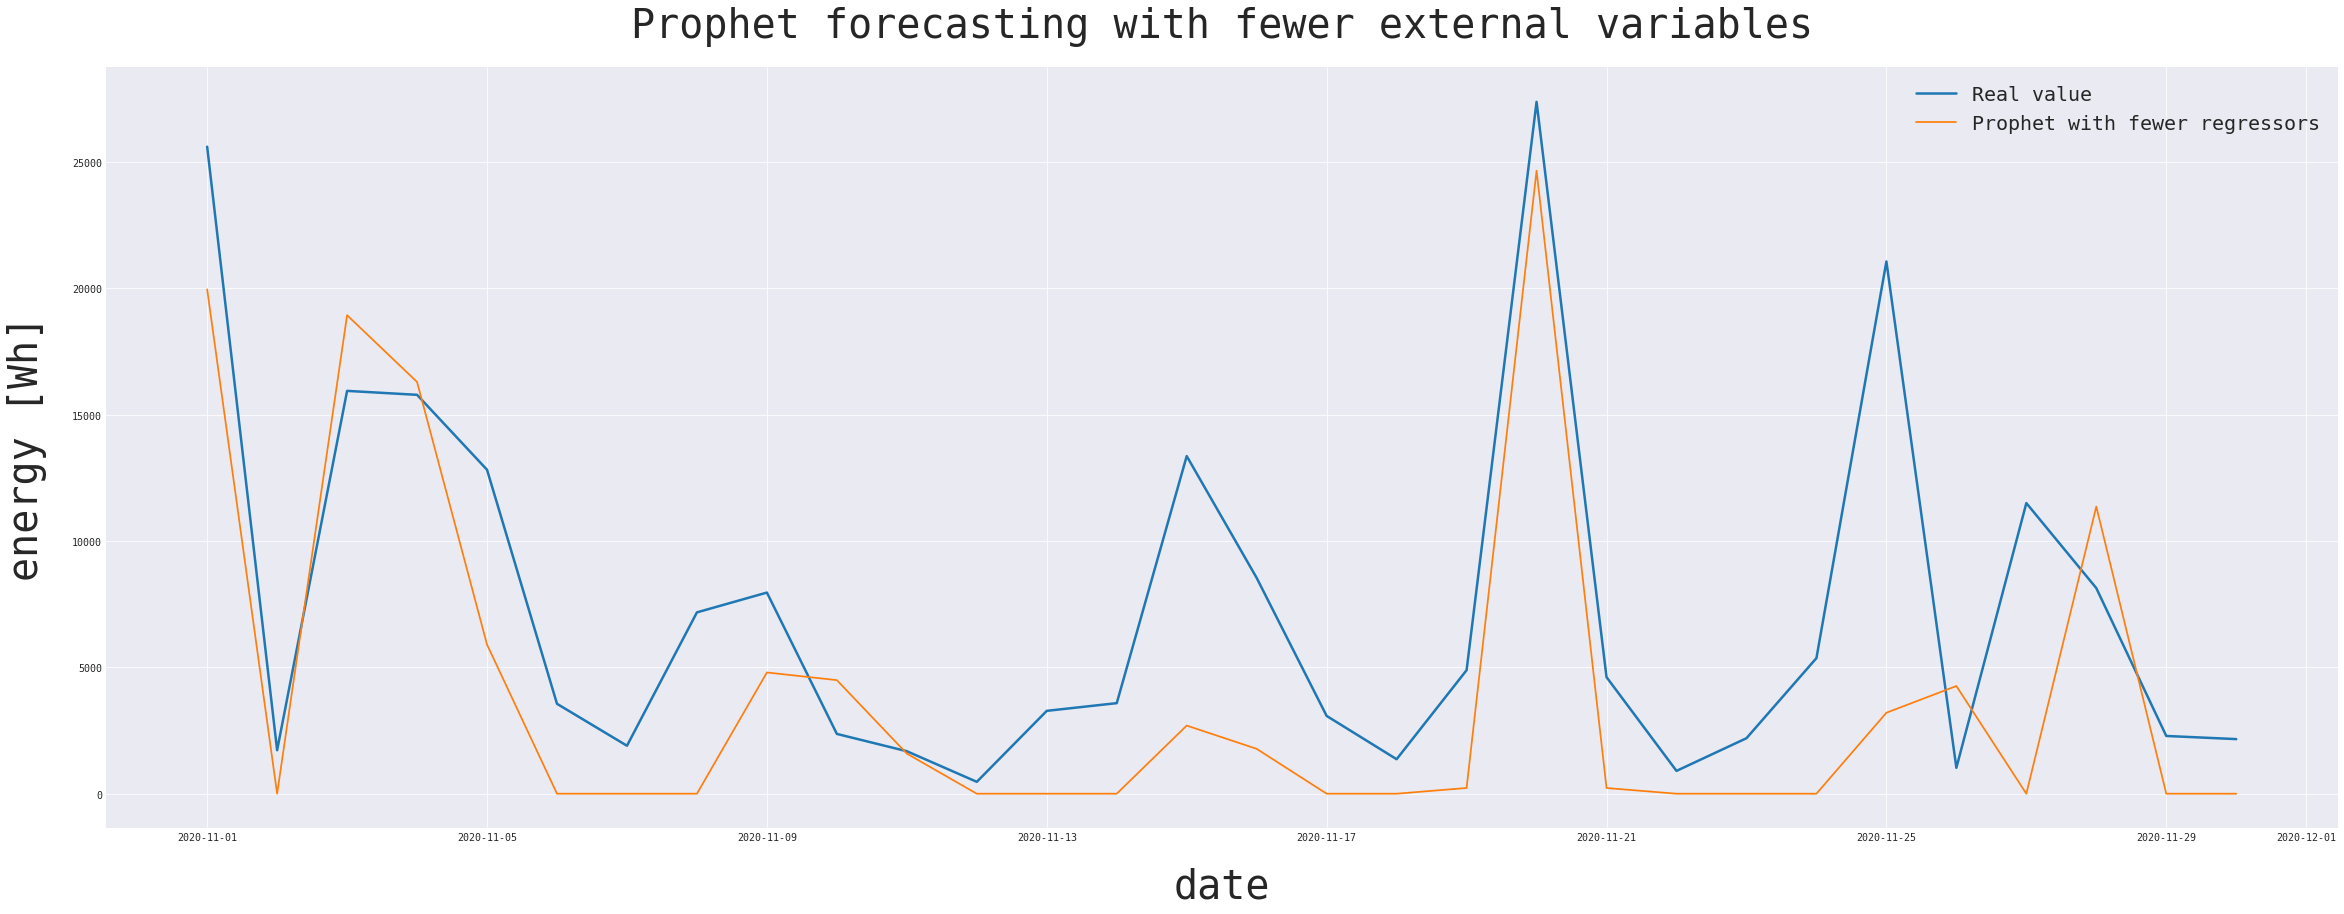

In [28]:
test['Prophet with fewer regressors'] = prophet_with_fewer_regressors(train, test)

plot_data = test
fig = plt.figure(figsize=(40,14))
plt.xlabel('date',fontsize=40, labelpad=25)
plt.ylabel('energy [Wh]',fontsize=40, labelpad=25)
plt.plot(plot_data['y'], linewidth=2.5)
plt.plot(plot_data['Prophet with fewer regressors'], linewidth=1.75)
plt.legend(['Real value','Prophet with fewer regressors', 'Moving average'], prop={'size': 20})
plt.title('Prophet forecasting with fewer external variables',fontsize=40, pad=30)
                                                 
# plt.show()
plt.savefig('prophet_fr.png')

In [29]:
final_evaluation = pd.DataFrame(CV_evaluation['Moving Average'].mean()).transpose()
final_evaluation = final_evaluation.append(pd.DataFrame(CV_evaluation['Prophet without regressors'].mean()).transpose())
final_evaluation = final_evaluation.append(pd.DataFrame(CV_evaluation['Prophet with regressors'].mean()).transpose())
final_evaluation = final_evaluation.append(pd.DataFrame(CV_evaluation['Prophet with fewer regressors'].mean()).transpose())

final_evaluation['model'] = ['Moving Average','Prophet without regressors','Prophet with regressors','Prophet with fewer regressors']
final_evaluation.set_index('model', inplace=True)
display(final_evaluation)
final_evaluation.to_html('final_evaluation.html')

,ME,MSE,RMSE,MAE,MPE,MAPE,U1,U2
model,,,,,,,,
Moving Average,-581.856977,2.064222e+08,13109.980501,10977.422093,-60.078129,85.785519,0.245735,0.865015
Prophet without regressors,-1300.862027,2.355665e+08,13746.089570,11722.623883,-37.836540,72.043319,0.272606,0.928225
Prophet with regressors,-1048.635098,8.566480e+07,8352.222840,7057.735309,-26.965930,53.955489,0.166595,0.671991
Prophet with fewer regressors,-776.823059,1.021681e+08,9178.062756,7837.312512,-22.487062,58.635851,0.193207,0.737731


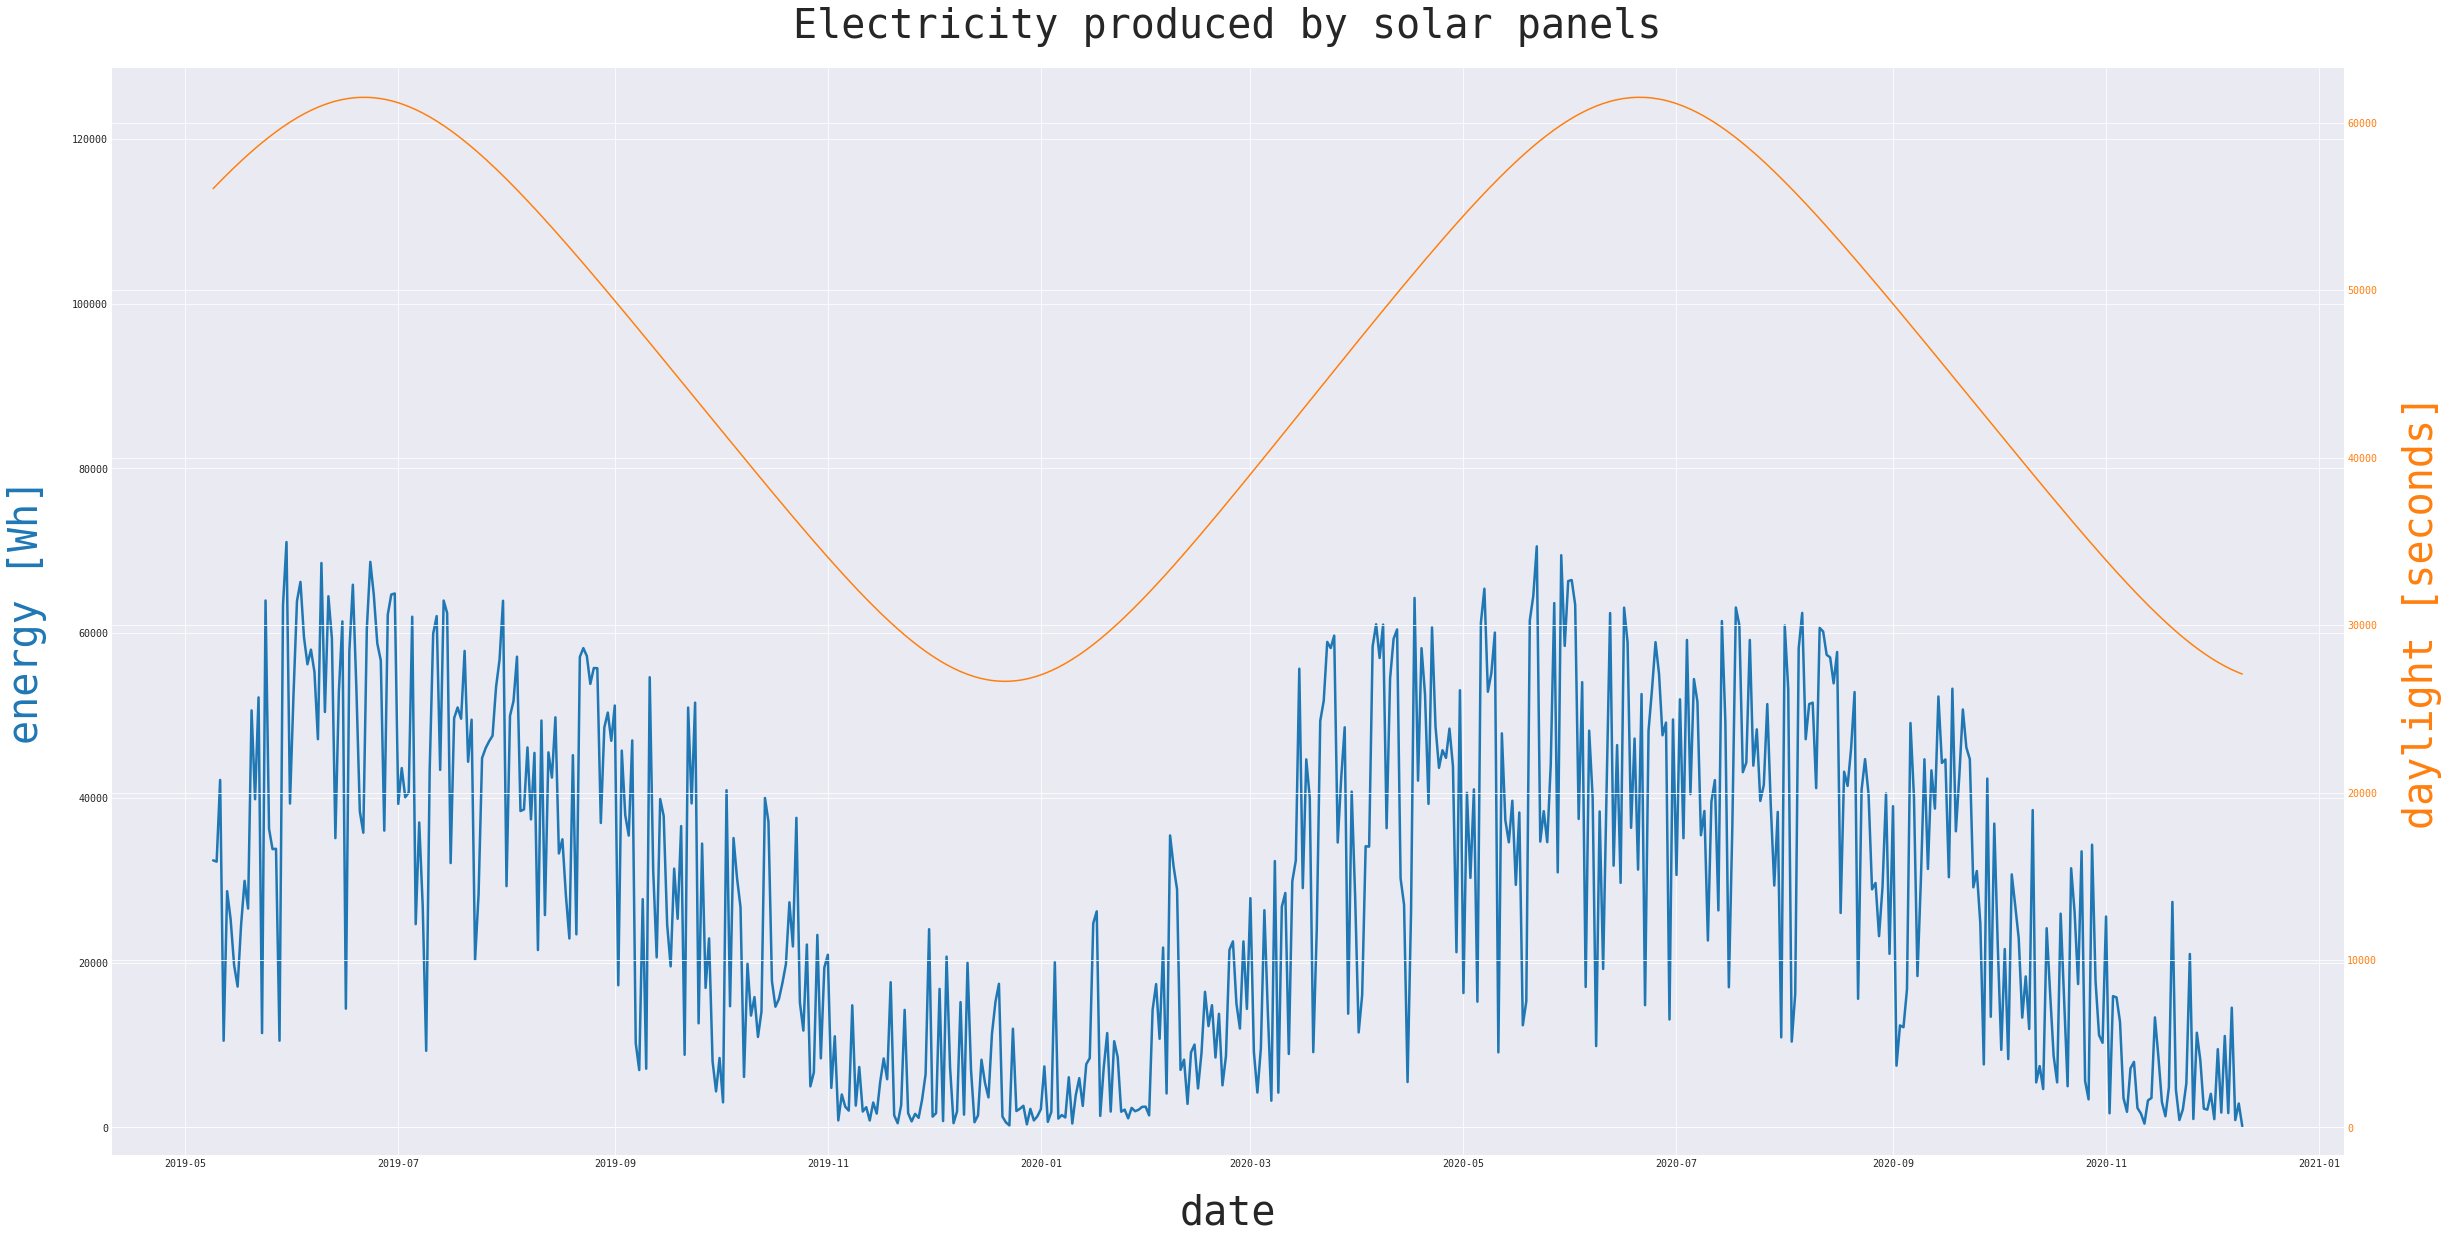

In [30]:
def align_yaxis(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = (ax1, ax2)
    extrema = [ax.get_ylim() for ax in axes]
    tops = [extr[1] / (extr[1] - extr[0]) for extr in extrema]
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [list(reversed(l)) for l in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    b_new_t = extrema[0][0] + tot_span * (extrema[0][1] - extrema[0][0])
    t_new_b = extrema[1][1] - tot_span * (extrema[1][1] - extrema[1][0])
    axes[0].set_ylim(extrema[0][0], b_new_t)
    axes[1].set_ylim(t_new_b, extrema[1][1])

fig, ax1 = plt.subplots(figsize=(40,20))
color = 'tab:blue'
ax1.set_xlabel('date',fontsize=40, labelpad=25)
# ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('energy [Wh]',color=color, fontsize=40, labelpad=25)
plt.title('Electricity produced by solar panels', fontsize=40, pad=30)
plt.plot((df['y']), linewidth=2.5)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('daylight [seconds]', color=color, fontsize=40, labelpad=25)  # we already handled the x-label with ax1
ax2.plot((df['daylight']), color=color)
ax2.tick_params(axis='y', labelcolor=color)
# ax1.axhline(linewidth=2, color="r") 
align_yaxis(ax1, ax2)

scale_factor = 1

ymin, ymax = ax2.get_ylim()

ax2.set_ylim(ymin * scale_factor, ymax * scale_factor)
# plt.show()
plt.savefig('daylight.png')

# GIF generation

In [53]:
df.columns

Index(['ds', 'y', 'Naive', 'Moving Average',
       'Temperature [2 m elevation corrected]', 'Temperature [1000 mb]',
       'Temperature [850 mb]', 'Temperature [700 mb]', 'Precipitation Total',
       'Snowfall Amount', 'Relative Humidity [2 m]', 'Wind Speed [10 m]',
       'Wind Direction [10 m]', 'Wind Speed [80 m]', 'Wind Direction [80 m]',
       'Wind Gust', 'Wind Speed [900 mb]', 'Wind Direction [900 mb]',
       'Wind Speed [850 mb]', 'Wind Direction [850 mb]', 'Wind Speed [700 mb]',
       'Wind Direction [700 mb]', 'Wind Speed [500 mb]',
       'Wind Direction [500 mb]', 'Cloud Cover Total',
       'Cloud Cover High [high cld lay]', 'Cloud Cover Medium [mid cld lay]',
       'Cloud Cover Low [low cld lay]', 'CAPE [180-0 mb above gnd]',
       'Sunshine Duration', 'Shortwave Radiation',
       'Direct Shortwave Radiation', 'Diffuse Shortwave Radiation',
       'Mean Sea Level Pressure [MSL]', 'Geopotential Height [1000 mb]',
       'Geopotential Height [850 mb]', 'Geopotentia

In [ ]:
date_range = (df['ds'].min(), df['ds'].max())
datelist = pd.date_range(*date_range, freq='D').tolist()

for date in datelist:
    start_date = date
    end_date = date + datetime.timedelta(days=10)
    if(end_date > df['ds'].max()):
        break
    start_date = datetime.datetime.strftime(start_date, '%Y-%m-%d')
    end_date = datetime.datetime.strftime(end_date, '%Y-%m-%d')
    
    adf = df.set_index("ds")[start_date:end_date]
    fig, axs = plt.subplots(2, figsize=(40,20))
    plt.xlabel('date',fontsize=35, labelpad=25)
    axs[0].plot(adf['y'], linewidth=5, color='tab:red')
    axs[0].set_ylabel('energy [Wh]',color='tab:red', fontsize=25, labelpad=25)
    axs[0].set_ylim(0, df['y'].max())

    axs[1].plot( adf['Temperature'], color='tab:orange')
    axs[1].set_ylabel('Temperature [°C]', color='tab:orange', fontsize=25, labelpad=25) 
    axs[1].set_ylim(0, df['Temperature'].max())

    axs_2 = axs[1].twinx() 
    axs_2.bar(adf.index, adf['Precipitation Total'],color='tab:grey')
    axs_2.set_ylim(0, df['Cloud Cover Total'].max())
    axs_2.set_ylabel('Cloud Cover [%]', color='tab:grey', fontsize=40, labelpad=25)
    plt.savefig(f'gif/{start_date}.png')

In [33]:
import imageio
images = []

datelist.sort()
#Generate GIF
with imageio.get_writer('energy_vs_weather_animated_2.gif', mode='I') as writer, yaspin().clock as sp:
    sp.text = "Generating animated meteogram."
    for date in datelist[:60]:
        filename = f"gif/{datetime.datetime.strftime(date, '%Y-%m-%d')}.png"
        try:
            image = imageio.imread(filename)
            writer.append_data(image)
        except:
            pass
            print(filename)


 Generating animated meteogram.